In [1]:
# Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import seaborn as sns
import pickle
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
# import helper functions
import sys
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *
from evaluation_helper import *
%matplotlib inline

from sklearn.metrics import roc_curve, auc

from tensorflow.keras.preprocessing import image
from tensorflow.keras import models


# List the file names of saved models and choose your model

In [2]:
# Paths
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [3]:
# os.listdir(checkpoint_path)

In [4]:
#os.listdir(training_history_path)

# Set the model name

In [24]:
# Pull the name of the model
weights='model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned2.csv'

number_of_images = 'all'

history=weights+'.pickle'

In [25]:
# Create train-test dataset

# Test train split, plus the features that are used to binarize the data
X_train_images, X_val_images, \
X_train_hier, X_val_hier, \
y_train_bin, y_val_bin, \
features = train_test_split_custom(number_of_images,
                                   csv = csv,
                                   random_state=44,
                                   multiple_input= True)

# Load the model
There are two different ways to load the model

## Option 1 : load the saved model:

In [77]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [78]:
# Setup the multi-input model from https://www.programcreek.com/python/example/89660/keras.layers.concatenate
num_label = y_train_bin.shape[1]

def getMultiModel():
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
    
    # Setup the trainability of the VGG
    base_model.trainable = False if open_layers < 1 else True
    
    for layer in base_model.layers[:-(open_layers+1):]:
        layer.trainable =  False
    
    x = base_model.get_layer('block5_pool').output
    

    x = Flatten()(x)
    
    x = Dense(512, activation='relu', name='fc_1')(x)
    
    input_2 = Input(shape=X_train_hier.shape[1], name="hier")
    
    hier_layer = Dense(32, activation='relu', name = 'fc_hier')(input_2)
    
    merge_one = concatenate([x, hier_layer])
    
    merge_one = Dense(512, activation='relu', name='fc_2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(num_label, activation='sigmoid')(merge_one)
    
    # Define the models
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model 


In [40]:
# Checkpoint path for weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [1]:
# new_model.summary()

# Predictions for the test dataset
You need these datasets and predictions to evaluate the model

In [60]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
dataset_multi_train = create_dataset_multi(X_train_images,X_train_hier, y_train_bin)
dataset_multi_val = create_dataset_multi(X_val_images,X_val_hier, y_val_bin)

You either have to make predictions with the model or load them from memory

In [8]:
# Make the predictions
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds

# predictions_test = new_model.predict(dataset_multi_val)

#predictions_train = new_model.predict(train_ds)

In [9]:
# SAVE the prediction
# pickle.dump(predictions_test, open( "best_multi_predictions.p", "wb" ) )

In [15]:
# Optional step - load the predictions from file
# Load the prediction
predictions_test= pickle.load( open( "best_multi_predictions.p", "rb" ) )

# Evaluations

## Loss plots

In [28]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))


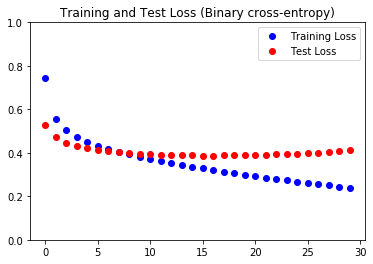

In [17]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

In [22]:
predictions_test.shape

(6671, 184)

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f809056a400>)

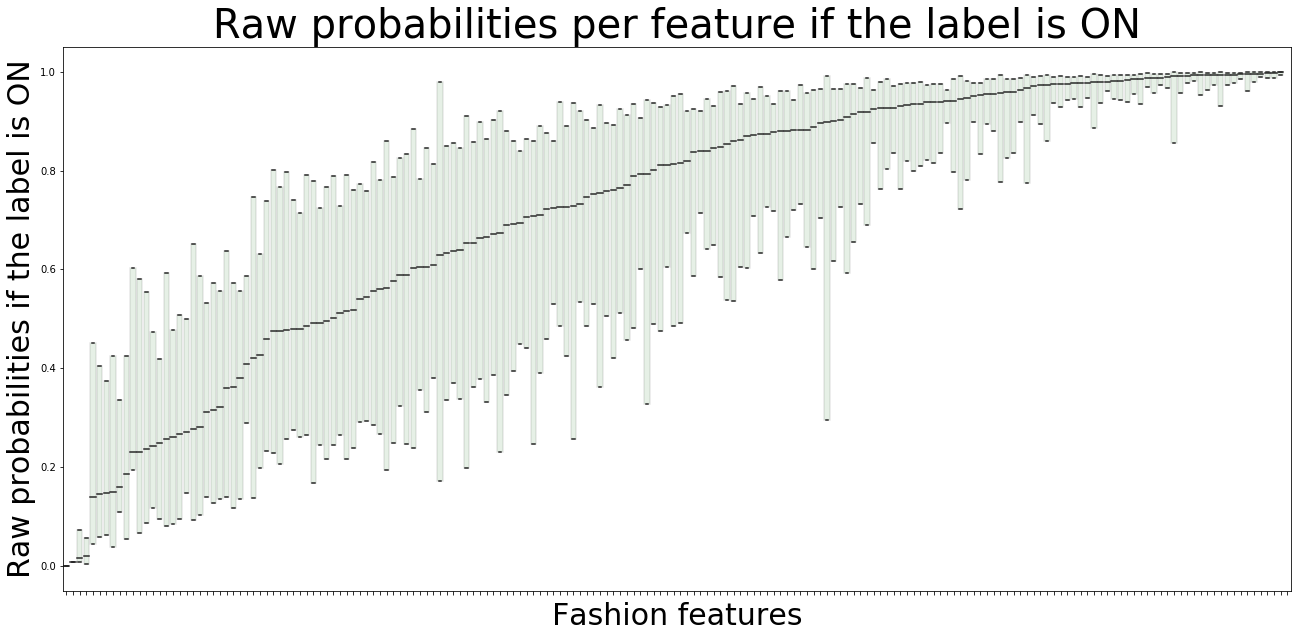

In [26]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features)

## Recall on 1, recall on 0

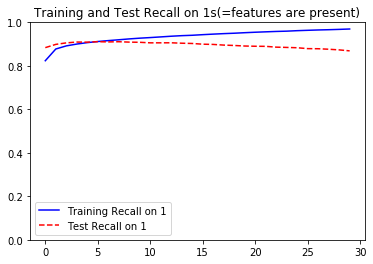

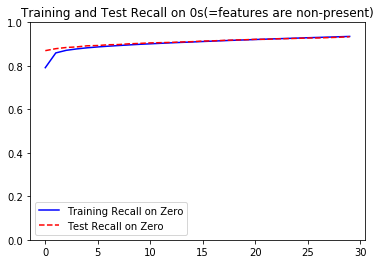

In [29]:
plot_training_history_recall_on_one(history)
plot_training_history_recall_on_zero(history)

# Precision

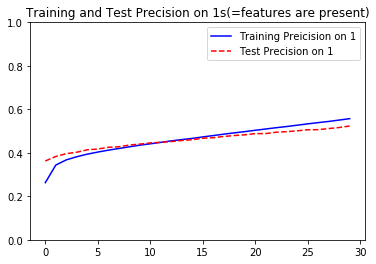

In [30]:
plot_training_history_precision_on_one(history)

## Precision - Recall curve with F1

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8093d7bb70>)

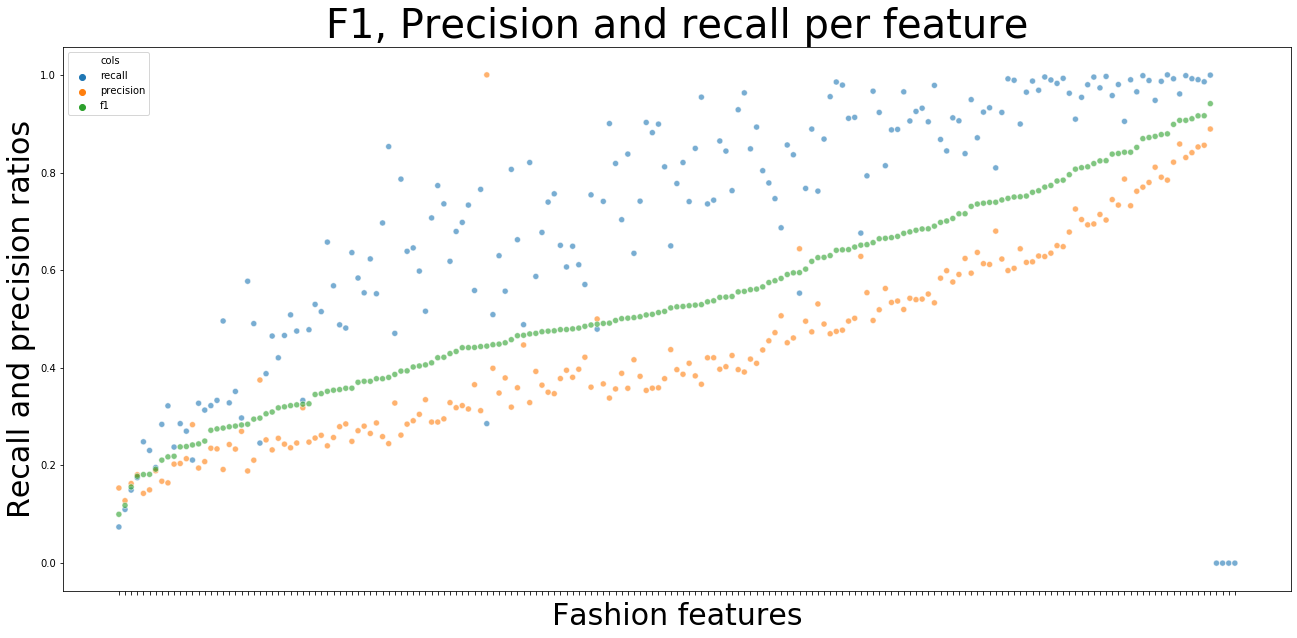

In [31]:
precision_recall_f1(y_val_bin, predictions_test, features)

## Make a prediction for an image

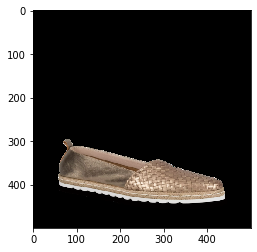

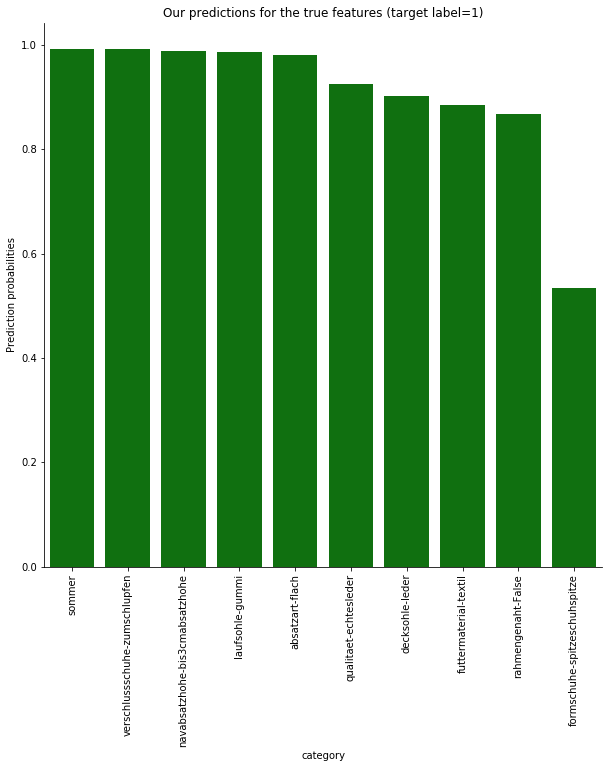

In [32]:
doPrediction(0, features, X_val_images, y_val_bin, predictions_test)

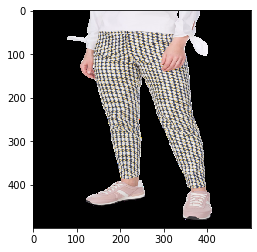

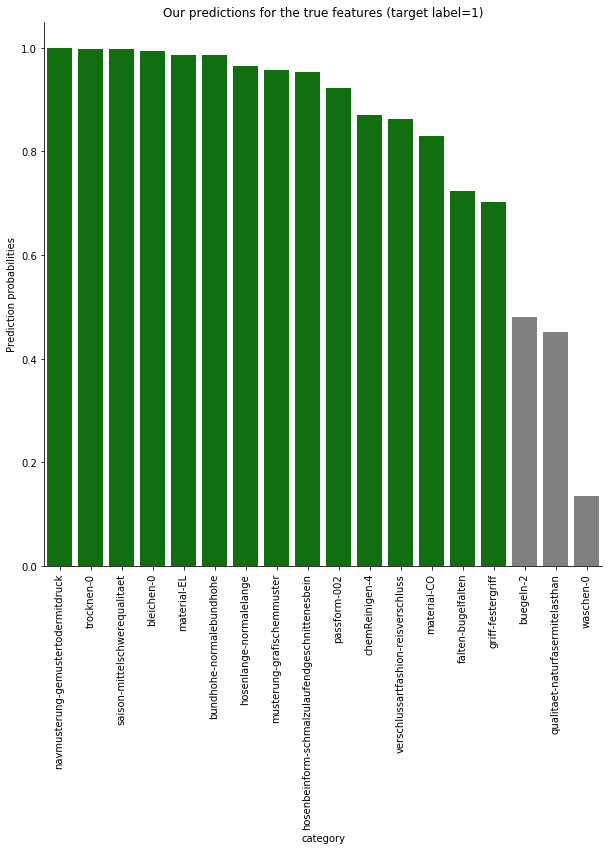

In [33]:
doPrediction(1,features, X_val_images, y_val_bin, predictions_test)

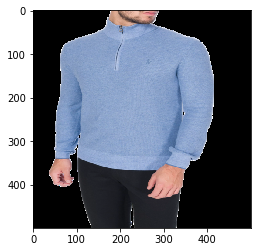

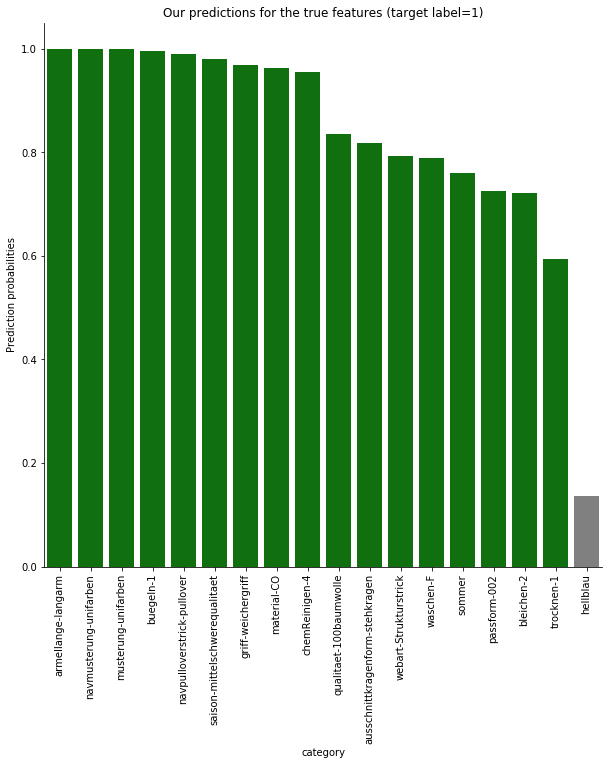

In [34]:
doPrediction(3,features, X_val_images, y_val_bin, predictions_test)

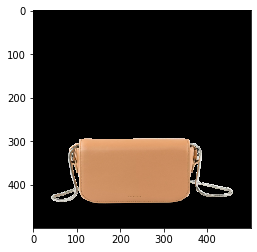

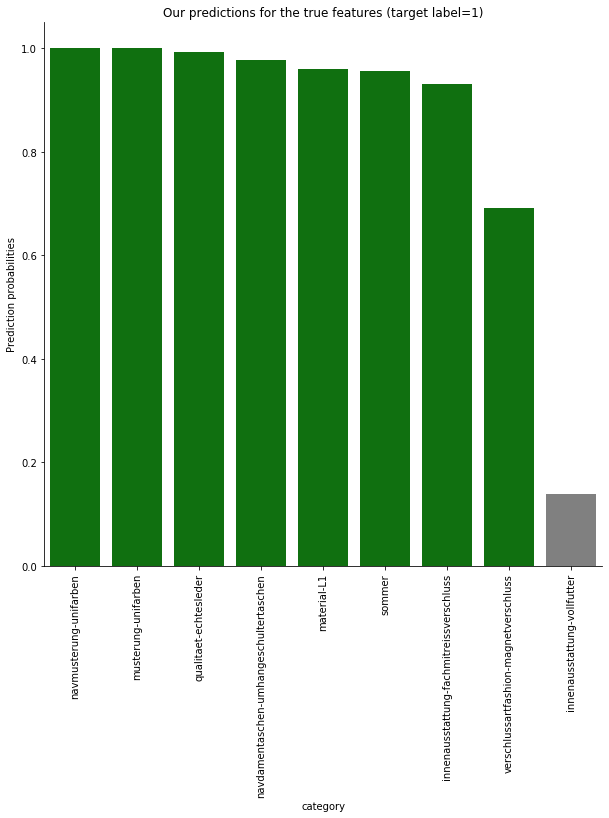

In [35]:
doPrediction(4,features, X_val_images, y_val_bin, predictions_test)

## ROC AUC curve

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f808fc18a20>)

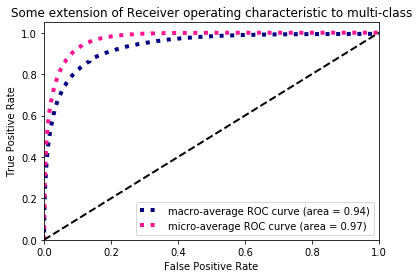

In [36]:
grouped_roc(y_val_bin, predictions_test)

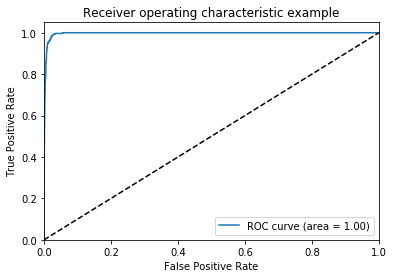

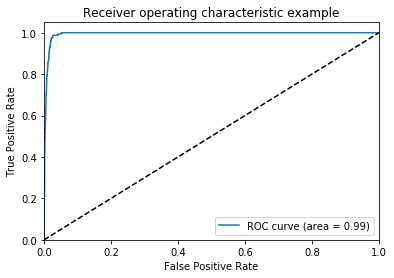

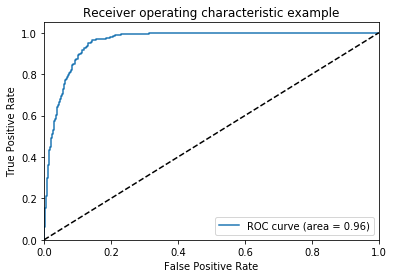

In [37]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [38]:
# ROC AUC scores per feature
for i in range(119):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


{0: 0.9969360616527013,
 1: 0.994313334731837,
 2: 0.9572573778126956,
 3: 0.9938573982025061,
 4: 0.9666144922420019,
 5: 0.998033036848793,
 6: 0.8378222492771268,
 7: 0.9676688659739507,
 8: 0.9889070238280642,
 9: 0.8694921362384628,
 10: 0.9670704336736115,
 11: 0.992289285099257,
 12: 0.9930501660924371,
 13: 0.9897293756679423,
 14: 0.9689570033355431,
 15: 0.9920572066779804,
 16: 0.9917012792134039,
 17: 0.9746531006365782,
 18: 0.9299704270383057,
 19: 0.9460448621421131,
 20: 0.8924443639583082,
 21: 0.8292302205983559,
 22: 0.9862382149752392,
 23: 0.9815694536435507,
 24: 0.9117538995958449,
 25: 0.9851812001434616,
 26: 0.8306592129586381,
 27: 0.9702187155766947,
 28: 0.933571175529688,
 29: 0.9813222343295046,
 30: 0.9391446894914302,
 31: 0.985825374954467,
 32: 0.9808755742985824,
 33: 0.9461487753190215,
 34: 0.8500739317177424,
 35: 0.8554419172645399,
 36: 0.8761803348649891,
 37: 0.9326715715561928,
 38: 0.8366036219134866,
 39: 0.8728301042713055,
 40: 0.86500916

## Visualizing the CNN layers - how the model sees an image 

In [40]:
# layer_outputs = [layer.output for layer in new_model.layers[1:23]] 
# # Extracts the outputs of the top 12 layers

# activation_model = models.Model(inputs=new_model.input[0], outputs=layer_outputs)
# # Creates a model that will return these outputs, given the model input

In [42]:
# new_model.layers[19]

In [ ]:
df_test = pd.read_csv('../1_cleaning/metadata_cleaned2.csv')

img_path1=df_test['image_path'][0]



In [ ]:
img = image.load_img(img_path1, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [ ]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

# Clustering features

In [43]:
recall_precision_frequency = create_recall_precision_frequency_df(predictions_test, y_val_bin, features)

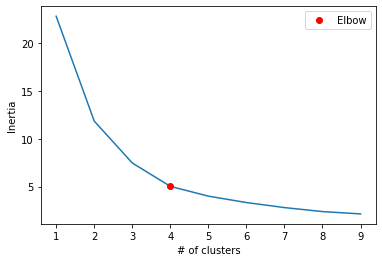

In [44]:
cluster_elbow(recall_precision_frequency,cluster_mark=4)

In [45]:
recall_precision_frequency_labeled = cluster_features(recall_precision_frequency, num_clusters=4)

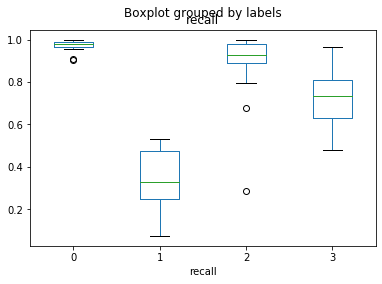

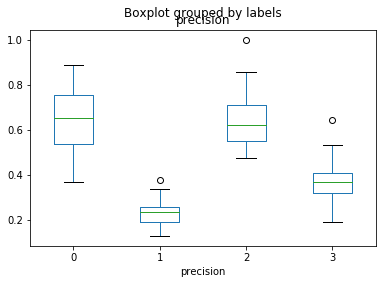

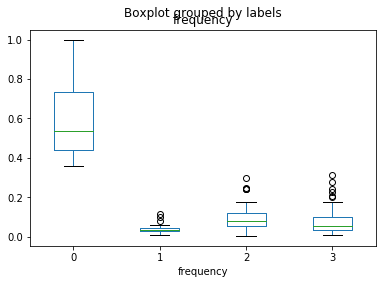

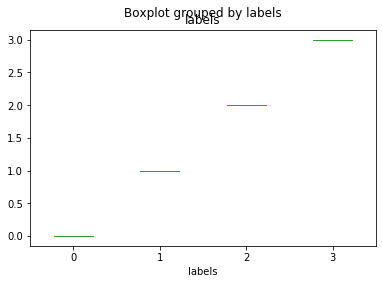

In [46]:
for feature in recall_precision_frequency.columns:
    recall_precision_frequency_labeled.boxplot(column=feature, by='labels', grid=False)
    plt.xlabel(feature)

# Heatmaps of features

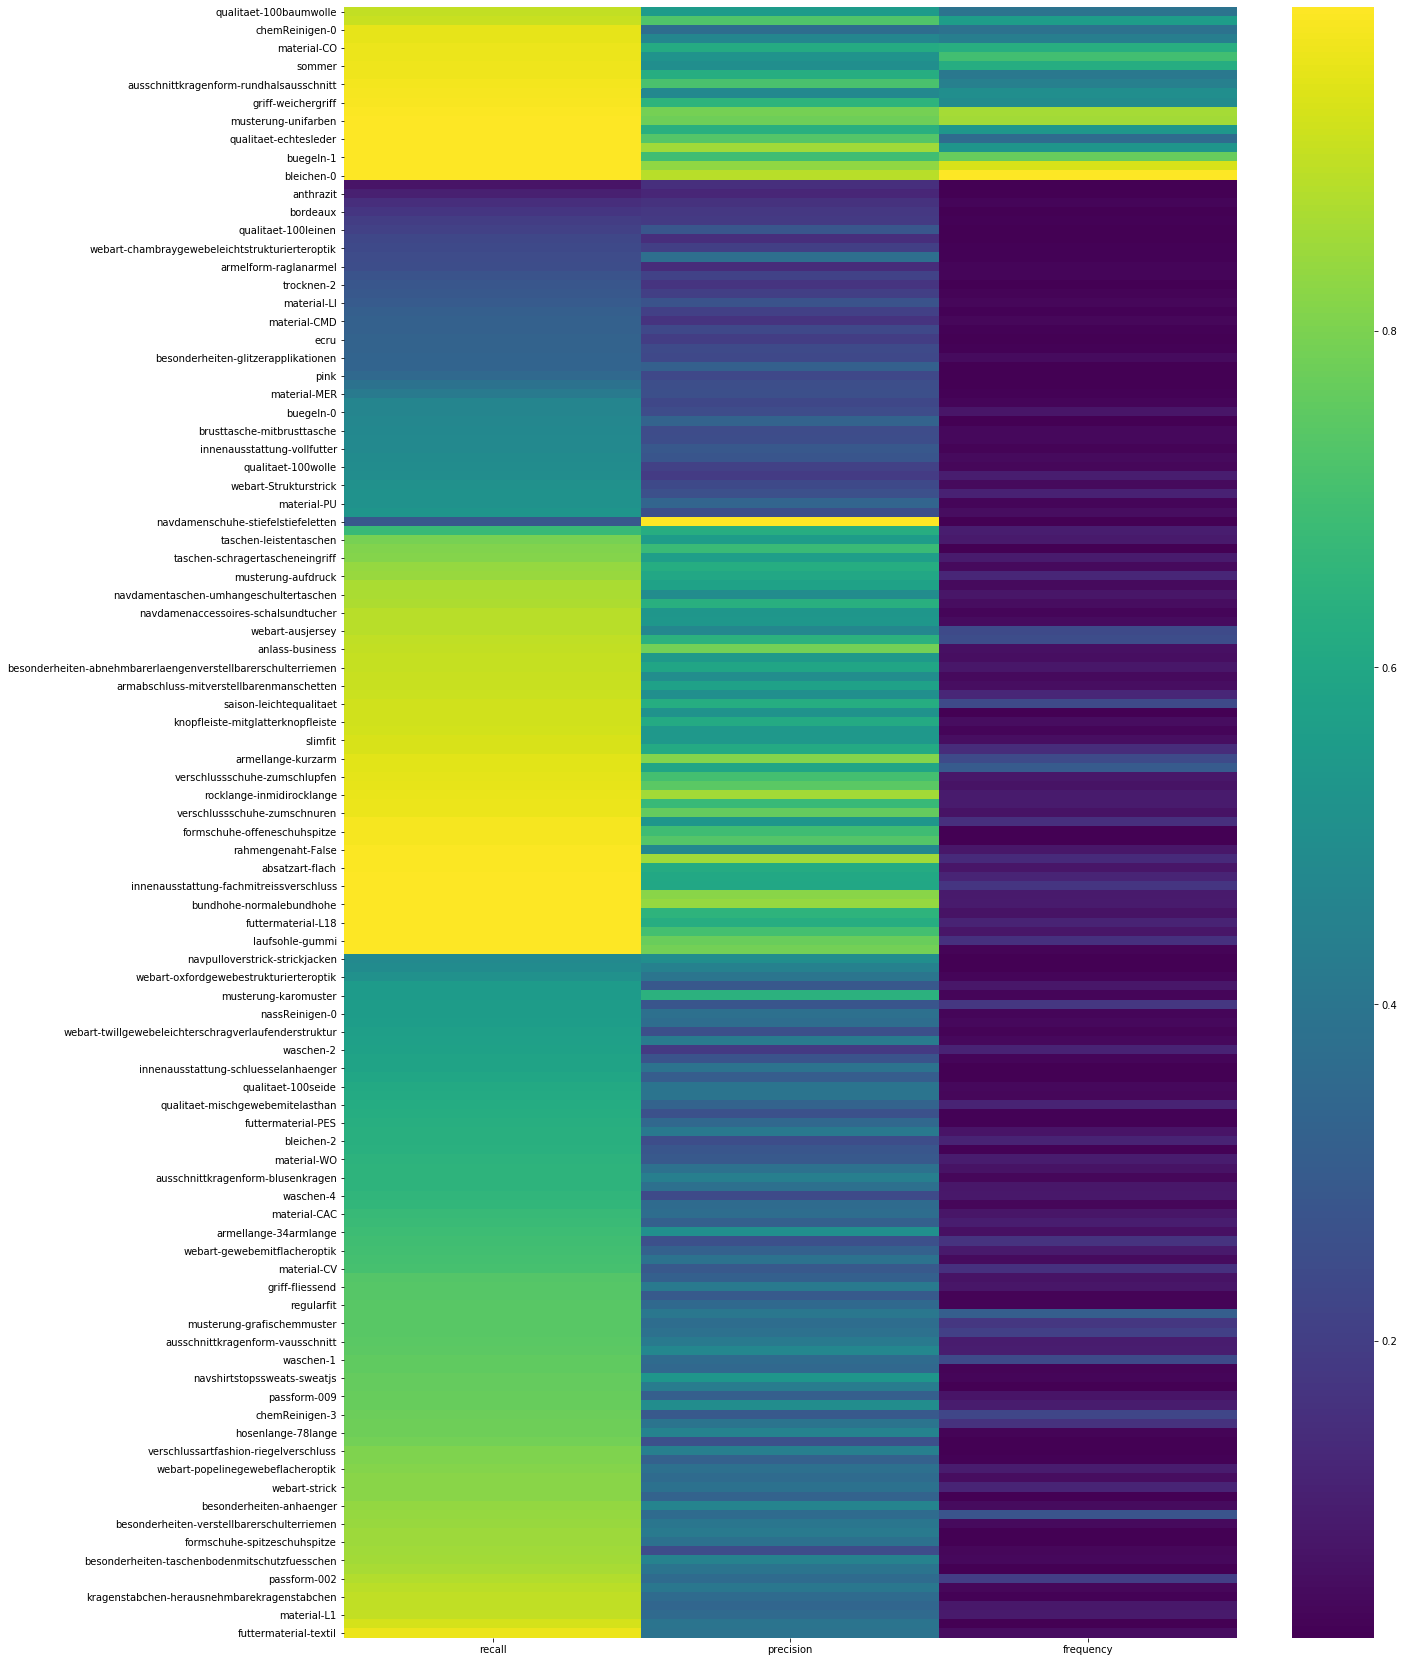

In [47]:
sortedDf = recall_precision_frequency_labeled.sort_values(by=['labels','recall'])
plt.figure(figsize=(20,30))
sns.heatmap(sortedDf.drop(labels=['labels'],axis=1), cmap='viridis', robust = True)
ax = plt.gca()
# ax.set_yticks([])

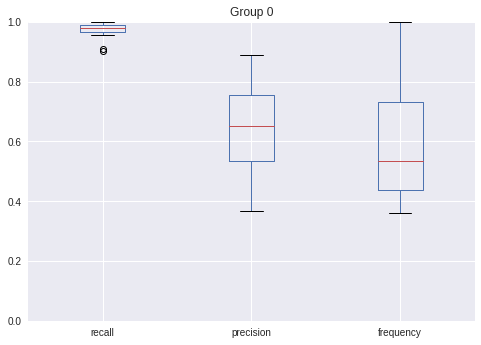

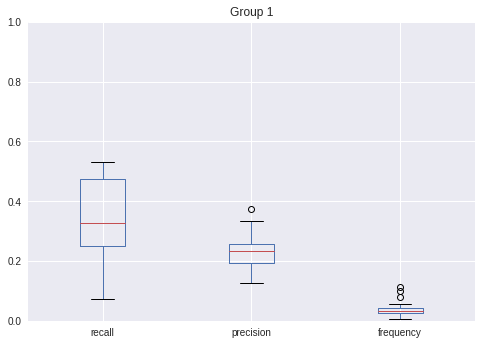

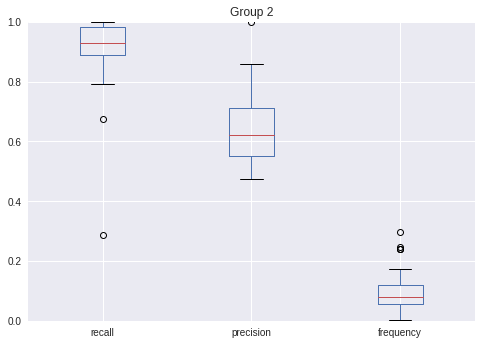

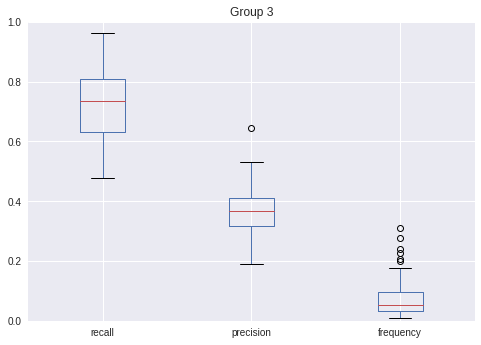

In [48]:
plt.style.use('seaborn')
# Plot by group
for group in range(4):
    temp = recall_precision_frequency_labeled[recall_precision_frequency.labels == group]
    temp[['recall','precision','frequency']].boxplot()
    plt.title('Group ' + str(group))
    plt.ylim((0, 1))
    plt.show()

In [49]:
recall_precision_frequency_labeled['f1'] = f1_score(recall_precision_frequency_labeled,'recall','precision')

In [50]:
# Set the points that you could use
things_to_keep = [
#     'rosa',
#     'grün',
#     'pink',
#     'formschuhe-runderschuhspitze',
#     'ausschnittkragenform-rundhalsausschnitt',
#     'armellange-langarm',
#     'sommer',
#     'winter',
#     'hosenlange-normalelange',
#     'qualitaet-mischgewebemitelasthan',
#     'qualitaet-kunstmischgewebe'
]

In [51]:
recall_precision_frequency_labeled['recall'].sort_values()

navblusentuniken-schlupfblusen                    0.074074
anthrazit                                         0.110000
beige                                             0.149660
bordeaux                                          0.175000
offwhite                                          0.195804
qualitaet-100leinen                               0.211111
besonderheiten-applikationen                      0.230769
webart-chambraygewebeleichtstrukturierteroptik    0.237705
grün                                              0.245902
armelform-raglanarmel                             0.248521
braun                                             0.270270
trocknen-2                                        0.284211
navdamenschuhe-stiefelstiefeletten                0.285714
rosa                                              0.285714
material-LI                                       0.297297
waschen-G                                         0.313433
material-CMD                                      0.3221

In [52]:
#Set the names of the groups
names_of_groups = ['low frequency, average recognition',
                  'low frequency, excellent recognition',
                  'high frequency, excellent recognition',
                  'low frequency, poor recognition']

recall_precision_frequency_labeled['Groups'] = recall_precision_frequency_labeled['labels'].map(dict(zip(range(4),names_of_groups)))
    

In [53]:
recall_precision_frequency_labeled = recall_precision_frequency_labeled.merge(get_feature_counts().set_index('feature'), left_index=True, right_index=True)

In [54]:
recall_precision_frequency_labeled['recall'] = recall_precision_frequency_labeled.recall*100

In [55]:
def formatter(num):
    temp = str(num)
    if len(temp)>3:
        end = temp[-3:]
        beg = temp[:-3]
        return beg + ' ' + end
    else:
        return temp

Text(0, 0.5, 'Recall: Ability for the model to recognize the feature')

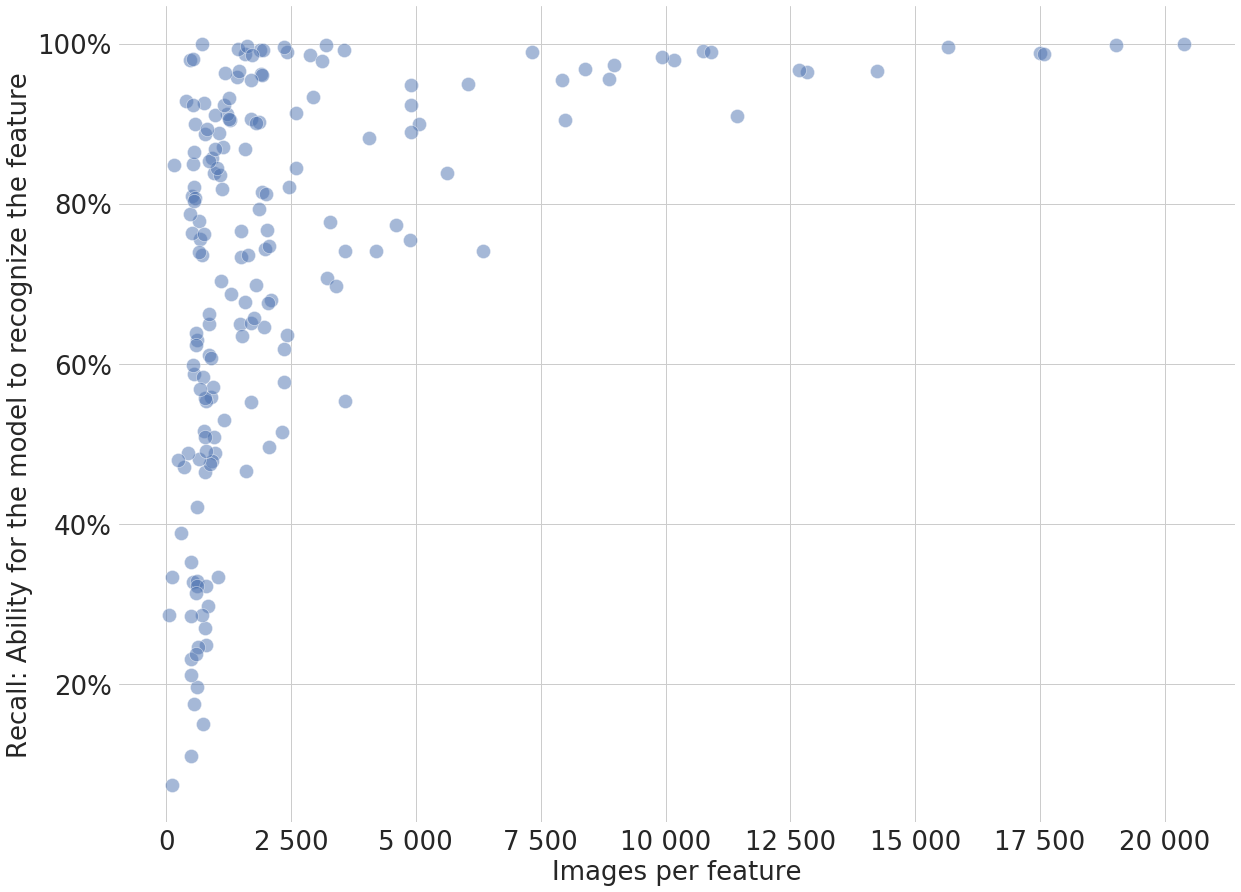

In [62]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot( 'count' ,'recall', alpha=.5,
                data=recall_precision_frequency_labeled, 
                ax=ax,
                s=200)

# Moves the text to the right a little
epsilon=.007
fontsize=15
for i, txt in enumerate(recall_precision_frequency_labeled.index.to_list()):
    if txt in things_to_keep:
        ax.annotate(txt, 
                    (recall_precision_frequency_labeled.frequency[i]+epsilon, 
                     recall_precision_frequency_labeled.f1[i]),
                     fontsize=fontsize)
# leg = plt.legend(loc='lower right', frameon=True, prop={'size': 25})
# leg.get_frame().set_linewidth(1.0)
# leg.get_frame().set_edgecolor('black')

ax.tick_params(labelsize=26)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, loc: formatter(int(x))))
font_axes={'size':26}
ax.set_xlabel("Images per feature", font_axes)
ax.set_ylabel("Recall: Ability for the model to recognize the feature", font_axes)

In [24]:
threshold = .5
(recall_precision_frequency_labeled.recall>threshold).sum()/recall_precision_frequency_labeled.shape[0]

0.7988826815642458

In [25]:
y = recall_precision_frequency_labeled.sort_values('count',axis=0)['count'].values

In [26]:
y[:int(len(y)*.5)]

array([  62,  122,  123,  158,  236,  306,  359,  403,  429,  471,  484,
        491,  495,  500,  503,  506,  514,  515,  532,  533,  536,  537,
        542,  548,  549,  550,  552,  565,  571,  574,  597,  597,  599,
        605,  607,  611,  612,  615,  616,  628,  648,  649,  665,  672,
        674,  709,  710,  720,  729,  731,  755,  758,  761,  774,  775,
        777,  785,  786,  787,  788,  799,  801,  815,  842,  851,  854,
        861,  864,  886,  888,  899,  908,  926,  928,  964,  967,  971,
        985,  986, 1026, 1047, 1056, 1079, 1088, 1117, 1141, 1153, 1161,
       1168])

In [27]:
x = np.linspace(0,1,len(y))

In [28]:
x

array([0.        , 0.00561798, 0.01123596, 0.01685393, 0.02247191,
       0.02808989, 0.03370787, 0.03932584, 0.04494382, 0.0505618 ,
       0.05617978, 0.06179775, 0.06741573, 0.07303371, 0.07865169,
       0.08426966, 0.08988764, 0.09550562, 0.1011236 , 0.10674157,
       0.11235955, 0.11797753, 0.12359551, 0.12921348, 0.13483146,
       0.14044944, 0.14606742, 0.15168539, 0.15730337, 0.16292135,
       0.16853933, 0.1741573 , 0.17977528, 0.18539326, 0.19101124,
       0.19662921, 0.20224719, 0.20786517, 0.21348315, 0.21910112,
       0.2247191 , 0.23033708, 0.23595506, 0.24157303, 0.24719101,
       0.25280899, 0.25842697, 0.26404494, 0.26966292, 0.2752809 ,
       0.28089888, 0.28651685, 0.29213483, 0.29775281, 0.30337079,
       0.30898876, 0.31460674, 0.32022472, 0.3258427 , 0.33146067,
       0.33707865, 0.34269663, 0.34831461, 0.35393258, 0.35955056,
       0.36516854, 0.37078652, 0.37640449, 0.38202247, 0.38764045,
       0.39325843, 0.3988764 , 0.40449438, 0.41011236, 0.41573

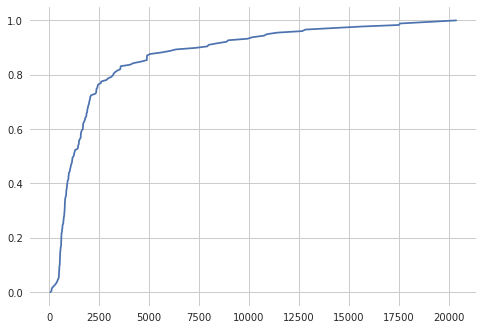

In [29]:
sns.lineplot(y,x)

In [30]:
sns.lineplot(x=recall_prequency_labeled.sort_values('count',axis=0).index, y='count', data=recall_precision_frequency_labeled.sort_values('count',axis=0))

NameError: name 'recall_prequency_labeled' is not defined

In [ ]:
recall_precision_frequency_labeled
for i in recall_precision_frequency_labeled.Groups.unique():
    print(f'Group: {i}')
    print(recall_precision_frequency_labeled[recall_precision_frequency_labeled['Groups']==i])

In [31]:
recall_precision_frequency_labeled['Groups']

absatzart-blockabsatz                                            low frequency, excellent recognition
absatzart-flach                                                  low frequency, excellent recognition
anlass-abend                                                    high frequency, excellent recognition
anlass-business                                                  low frequency, excellent recognition
anlass-casual                                                    low frequency, excellent recognition
anlass-freizeit                                                  low frequency, excellent recognition
anthrazit                                                          low frequency, average recognition
armabschluss-manschettenmiteinemknopf                           high frequency, excellent recognition
armabschluss-mitverstellbarenmanschetten                         low frequency, excellent recognition
armelform-raglanarmel                                              low frequency, 